In [1]:
import os
import numpy as np
from sentinelhub import CRS
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from lib.AOISegment import AOISegment
from sentinelhub import BBox, SHConfig
from sentinelhub import SentinelHubCatalog

In [2]:
load_dotenv()
config = SHConfig()
config.sh_client_id = os.environ.get("SENTINEL_HUB_CLIENT_ID")
config.sh_client_secret = os.environ.get("SENTINEL_HUB_CLIENT_SECRET")
catalog = SentinelHubCatalog(config=config)

In [4]:
eval_script_cloud = AOISegment.load_eval_script("eval_scripts/es_clm_binary.js")
eval_script_buildup = AOISegment.load_eval_script("eval_scripts/es_bua_binary.js")
eval_script_green = AOISegment.load_eval_script("eval_scripts/es_gc_binary.js")
eval_script_water = AOISegment.load_eval_script("eval_scripts/es_w_binary.js")

In [5]:
zurich = True

if zurich:
    bbox = BBox(bbox=(8.477, 47.336, 8.605, 47.417), crs=CRS.WGS84)
    time_stamp = "2025-04-23"
    image = PILImage.open("images/Zurich-2025-04-23.jpeg")
    image_np = np.array(image)

else:
    bbox = BBox(bbox=(8.629496, 47.5022965, 8.757201, 47.58301), crs=CRS.WGS84)
    time_stamp = "2024-06-19"
    image = PILImage.open("images/Winterthur-2024-06-19.jpeg")
    image_np = np.array(image)

cloud_mask = AOISegment.get_img(bbox=bbox,
                                eval_script=eval_script_cloud, time_stamp=time_stamp,
                                config=config
                                )
buildup_mask = AOISegment.get_img(bbox=bbox,
                                  eval_script=eval_script_buildup, time_stamp=time_stamp,
                                  config=config
                                  )
green_mask = AOISegment.get_img(bbox=bbox,
                                eval_script=eval_script_green, time_stamp=time_stamp,
                                config=config
                                )
water_mask = AOISegment.get_img(bbox=bbox,
                                eval_script=eval_script_water, time_stamp=time_stamp,
                                config=config
                                )

In [6]:
combined_mask = AOISegment.combine_masks(cloud_mask, buildup_mask, green_mask, water_mask)

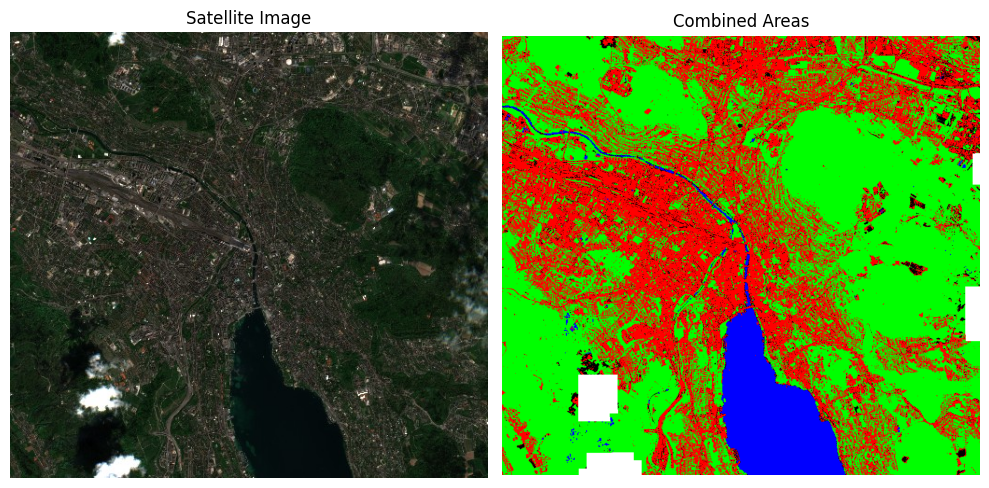

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np)
axs[0].axis("off")  # optional
axs[0].set_title("Satellite Image")  # optional

axs[1].imshow(combined_mask)
axs[1].axis("off")
axs[1].set_title("Combined Areas")

plt.tight_layout()
plt.show()